•	In the first cell of the notebook, explain why we do not need a collate function.

A collate function is used to sort data while following a customized criteria. However, in this case, we are using TF-IDF vectors, which are fixed-length numerical representations of the text data. Since these vectors have a consistent length, there's no need for custom collation. We can directly feed them into the neural network.

# <font color = 'indianred'>**HW4B - Prachi Dalal** </font>


# <font color = 'indianred'>**Load Dataset** </font>

In [200]:
#import necessary libraries
import torch
import torch.nn as nn
from torchtext.vocab import vocab

import random
import numpy as np

import joblib
from collections import Counter

from functools import partial

from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from torch.utils.data import Dataset, DataLoader
from torch.nn import EmbeddingBag, Linear, ReLU, Dropout, BatchNorm1d
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import hamming_loss

In [201]:
get_ipython()

In [202]:
# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext -qq
    !pip install torchinfo -qq

import os
os.chdir("/content/drive/MyDrive/BUAN 6342")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/BUAN 6342


In [204]:
file_path = "df_multilabel_hw_cleaned.joblib"
df = joblib.load(file_path)
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


# <font color = 'indianred'>**Prepare Dataset** </font>

- *Convert Tag_Number to Integers*
- *One Hot Encoding for Dependent Variable*

In [205]:
import ast

df['Tag_Number'] = df['Tag_Number'].apply(ast.literal_eval)

from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

mlb = MultiLabelBinarizer()
labels_encoded  = mlb.fit_transform(df['Tag_Number'])
labels_df = pd.DataFrame(labels_encoded, columns=mlb.classes_)

#merge
df = pd.concat([df, labels_df], axis=1)
df

,cleaned_text,Tags,Tag_Number,0,1,2,3,4,5,6,7,8,9
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]",1,0,0,0,0,0,0,0,0,1
1,run javascript code server java code want run ...,java javascript,"[1, 3]",0,1,0,1,0,0,0,0,0,0
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]",1,0,0,0,0,0,0,0,0,1
3,run python script php server run nginx web ser...,php python,"[2, 7]",0,0,1,0,0,0,0,1,0,0
4,advice write function m try write function res...,javascript jquery,"[3, 5]",0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47423,listen phone state application nee liste phone...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47424,android ui thread thread task want access main...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]",0,0,0,1,0,0,0,0,0,1


In [206]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df.iloc[:, 3:]

# Split the data into train (60%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Reset the indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Split rest of 40% by half into validation (20%) and test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reset the indices
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Convert to list of strings
X_train_list = X_train.tolist()
X_valid_list = X_valid.tolist()
X_test_list = X_test.tolist()

y_train_np = y_train.to_numpy()
y_valid_np = y_valid.to_numpy()
y_test_np = y_test.to_numpy()

# Check
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Train set indices:", X_train.index)
print("Validation set indices:", X_valid.index)
print("Test set indices:", X_test.index)

print(type(X_train_list))
print(type(y_train_np))

Train set shape: (28456,) (28456, 10)
Validation set shape: (9485,) (9485, 10)
Test set shape: (9486,) (9486, 10)
Train set indices: RangeIndex(start=0, stop=28456, step=1)
Validation set indices: RangeIndex(start=0, stop=9485, step=1)
Test set indices: RangeIndex(start=0, stop=9486, step=1)
<class 'list'>
<class 'numpy.ndarray'>


# <font color = 'indianred'>**Part B (Neural Network in PyTorch using Sparse Embeddings)** </font>


# <font color = 'indianred'>**(1) Model Training: Training and evaluation on Validation set** </font>

In [207]:
# Model Parameters
MAX_FEATURES = 5000
NEURONS_HIDDEN1 = 200
NEURONS_HIDDEN2 = 100
DROP_PROB1 = 0.5
DROP_PROB2 = 0.5
NUM_OUTPUTS = 10
INPUT_SIZE = MAX_FEATURES

# Training Parameters
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0
CLIP_TYPE = 'value'
CLIP_VALUE = 10
PATIENCE = 5
OPTIMIZER = 'AdamW'

In [208]:
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_tfidf = vectorizer.fit_transform(X_train_list)
X_valid_tfidf = vectorizer.transform(X_valid_list)
X_test_tfidf = vectorizer.transform(X_test_list)

In [209]:
# Convert to PyTorch sparse tensors
X_train_sparse = torch.tensor(X_train_tfidf.todense(), dtype=torch.float32)
X_valid_sparse = torch.tensor(X_valid_tfidf.todense(), dtype=torch.float32)
X_test_sparse = torch.tensor(X_test_tfidf.todense(), dtype=torch.float32)

In [210]:
# One-hot encoding of labels
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

In [211]:
from scipy.sparse import csr_matrix, issparse

# Check if X_train_tfidf is sparse
print("X_train_tfidf is sparse:", issparse(X_train_tfidf))

# Check if X_valid_tfidf is sparse
print("X_valid_tfidf is sparse:", issparse(X_valid_tfidf))

# Check if X_test_tfidf is sparse
print("X_test_tfidf is sparse:", issparse(X_test_tfidf))

X_train_tfidf is sparse: True
X_valid_tfidf is sparse: True
X_test_tfidf is sparse: True


In [212]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [213]:
# Create datasets and dataloaders
train_dataset = CustomDataset(X_train_sparse, y_train_tensor)
valid_dataset = CustomDataset(X_valid_sparse, y_valid_tensor)
test_dataset = CustomDataset(X_test_sparse, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [215]:
for inputs, targets in train_loader:
    # Print the shape and type of the input and target tensors
    print("Input Shape:", inputs.shape, "Input Type:", inputs.dtype)
    print("Target Shape:", targets.shape, "Target Type:", targets.dtype)
    break
print("Number of Samples in Training Dataset:", len(train_loader.dataset))

Input Shape: torch.Size([128, 5000]) Input Type: torch.float32
Target Shape: torch.Size([128, 10]) Target Type: torch.float32
Number of Samples in Training Dataset: 28456


In [217]:
import torch.nn as nn
# Define the model
class MultilabelClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob1, dropout_prob2):
        super(MultilabelClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob1)
        self.dropout2 = nn.Dropout(dropout_prob2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size1)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size2)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x = self.hidden3(x)
        return torch.sigmoid(x)  # Sigmoid activation

In [218]:
from torchinfo import summary
import torch

# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = MultilabelClassifier(input_size=INPUT_SIZE, hidden_size1=NEURONS_HIDDEN1,
                              hidden_size2=NEURONS_HIDDEN2, output_size=NUM_OUTPUTS,
                              dropout_prob1=DROP_PROB1, dropout_prob2=DROP_PROB2)

# Move the model to the device
model = model.to(device)

# Generate some dummy input data
batch_size = 128
max_features = 5000
data = torch.randn((batch_size, max_features), dtype=torch.float32, device=device)

data = data.to(device)

summary(model, input_size=(batch_size, max_features), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
MultilabelClassifier                     [128, 10]                 --
├─Linear: 1-1                            [128, 200]                1,000,200
├─ReLU: 1-2                              [128, 200]                --
├─Dropout: 1-3                           [128, 200]                --
├─BatchNorm1d: 1-4                       [128, 200]                400
├─Linear: 1-5                            [128, 100]                20,100
├─ReLU: 1-6                              [128, 100]                --
├─Dropout: 1-7                           [128, 100]                --
├─BatchNorm1d: 1-8                       [128, 100]                200
├─Linear: 1-9                            [128, 10]                 1,010
Total params: 1,021,910
Trainable params: 1,021,910
Non-trainable params: 0
Total mult-adds (M): 130.80
Input size (MB): 2.56
Forward/backward pass size (MB): 0.62
Params size (MB): 4.09
Estimated Total Size (

In [219]:
output = model(data)

print(output)

tensor([[0.2733, 0.5563, 0.4510,  ..., 0.6192, 0.3422, 0.4059],
        [0.5807, 0.6667, 0.5127,  ..., 0.3736, 0.5406, 0.6074],
        [0.5155, 0.5291, 0.5952,  ..., 0.2632, 0.5008, 0.6831],
        ...,
        [0.3566, 0.4624, 0.5054,  ..., 0.6928, 0.5477, 0.4895],
        [0.7999, 0.6901, 0.6499,  ..., 0.6468, 0.5324, 0.5627],
        [0.7394, 0.3943, 0.4462,  ..., 0.5069, 0.4658, 0.4736]],
       grad_fn=<SigmoidBackward0>)


In [220]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5, clip_value=10):
    train_losses = []
    valid_losses = []
    train_hamming_losses = []
    valid_hamming_losses = []
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_hamming_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            # Clip gradients
            if CLIP_TYPE == 'value':
                nn.utils.clip_grad_value_(model.parameters(), clip_value)
            elif CLIP_TYPE == 'norm':
                nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_hamming_loss += hamming_loss(targets.numpy(), (outputs > 0.5)) * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_hamming_loss /= len(train_loader.dataset)
        train_hamming_losses.append(train_hamming_loss)

        # Evaluation on validation set
        model.eval()
        valid_loss = 0.0
        valid_hamming_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item() * inputs.size(0)
                valid_hamming_loss += hamming_loss(targets.numpy(), (outputs > 0.5)) * inputs.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        valid_hamming_loss /= len(valid_loader.dataset)
        valid_hamming_losses.append(valid_hamming_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Hamming Loss: {train_hamming_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Hamming Loss: {valid_hamming_loss:.4f}')

        # Early stopping based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered!")
                break

    return train_losses, valid_losses, train_hamming_losses, valid_hamming_losses


In [221]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, Dropout, BatchNorm1d
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import hamming_loss
import torch.nn.functional as F

# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Loss function
criterion = nn.BCELoss()

# Define the model
model_slack = MultilabelClassifier(input_size=MAX_FEATURES, hidden_size1=NEURONS_HIDDEN1, hidden_size2=NEURONS_HIDDEN2, dropout_prob1=DROP_PROB1, dropout_prob2=DROP_PROB2, output_size=NUM_OUTPUTS)


# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [222]:
print("Shape of X_train_tfidf:", X_train_tfidf.shape)

Shape of X_train_tfidf: (28456, 5000)


In [223]:
from torchinfo import summary

summary(model_slack, input_size=(BATCH_SIZE, INPUT_SIZE), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
MultilabelClassifier                     [128, 10]                 --
├─Linear: 1-1                            [128, 200]                1,000,200
├─ReLU: 1-2                              [128, 200]                --
├─Dropout: 1-3                           [128, 200]                --
├─BatchNorm1d: 1-4                       [128, 200]                400
├─Linear: 1-5                            [128, 100]                20,100
├─ReLU: 1-6                              [128, 100]                --
├─Dropout: 1-7                           [128, 100]                --
├─BatchNorm1d: 1-8                       [128, 100]                200
├─Linear: 1-9                            [128, 10]                 1,010
Total params: 1,021,910
Trainable params: 1,021,910
Non-trainable params: 0
Total mult-adds (M): 130.80
Input size (MB): 2.56
Forward/backward pass size (MB): 0.62
Params size (MB): 4.09
Estimated Total Size (

In [225]:
# inputs in the DataLoader will be a single sparse tensor
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)
    inputs = inputs.to(device)
    targets = targets.to(device)
    model_slack = model_slack.to(device)
    model_slack.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_slack(inputs)
        loss = criterion(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Input shape: torch.Size([128, 5000])
Actual loss: 0.6790309548377991
Expected Theoretical loss: 0.6931471805599453


In [226]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [227]:
# Train the model
train_losses, valid_losses, train_hamming_losses, valid_hamming_losses = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=EPOCHS)

Epoch 1/5, Train Loss: 0.3537, Train Hamming Loss: 0.1449, Valid Loss: 0.1451, Valid Hamming Loss: 0.0487
Epoch 2/5, Train Loss: 0.1382, Train Hamming Loss: 0.0485, Valid Loss: 0.1196, Valid Hamming Loss: 0.0438
Epoch 3/5, Train Loss: 0.1120, Train Hamming Loss: 0.0407, Valid Loss: 0.1111, Valid Hamming Loss: 0.0401
Epoch 4/5, Train Loss: 0.0954, Train Hamming Loss: 0.0345, Valid Loss: 0.1058, Valid Hamming Loss: 0.0381
Epoch 5/5, Train Loss: 0.0850, Train Hamming Loss: 0.0314, Valid Loss: 0.1036, Valid Hamming Loss: 0.0371


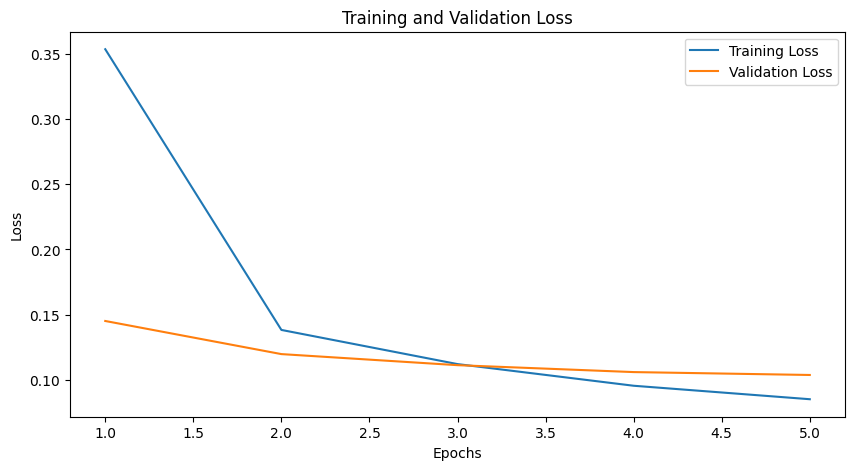

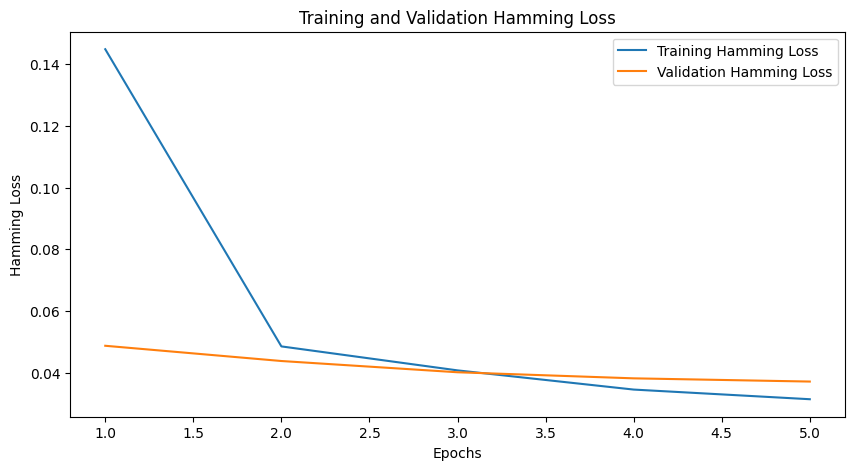

In [228]:
# Plotting
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_hamming_losses, label='Training Hamming Loss')
plt.plot(epochs, valid_hamming_losses, label='Validation Hamming Loss')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.title('Training and Validation Hamming Loss')
plt.legend()
plt.show()

In [231]:
# Prediction function
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
    return np.vstack(predictions)

# Make predictions on test set
test_predictions = predict(model, test_loader)

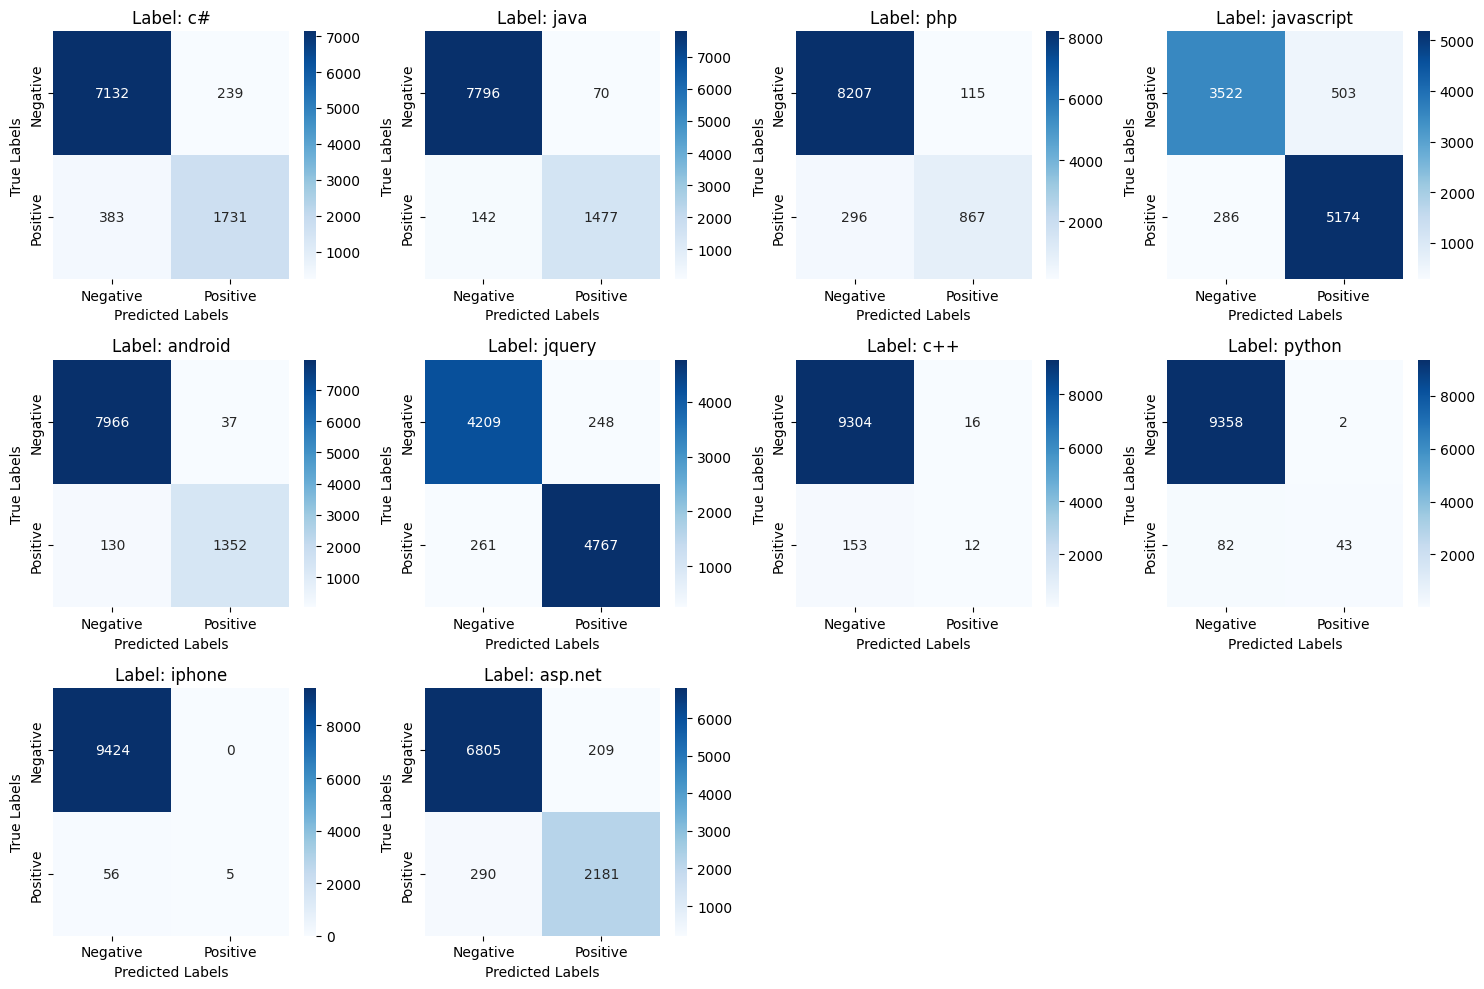

In [239]:
from sklearn.metrics import confusion_matrix

def plot_multilabel_confusion_matrices(confusion_matrices, labels):
    num_labels = len(labels)
    plt.figure(figsize=(15, 10))
    for i in range(num_labels):
        plt.subplot(3, 4, i + 1)
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title(f'Label: {labels[i]}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

# Define the class labels
labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Make predictions on test set
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Make predictions on validation set
valid_predictions = predict(model, valid_loader)
valid_predictions_binary = (valid_predictions > 0.5).astype(int)

# Compute confusion matrices for validation set
valid_confusion_matrices = multilabel_confusion_matrices(y_valid_np, valid_predictions_binary)

# Plot confusion matrices for validation set
plot_confusion_matrices(valid_confusion_matrices, labels)

# <font color = 'indianred'>**(2) Model Testing: evaluation on the test set** </font>

In [240]:
# Evaluate on test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

In [241]:
test_loss = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1074


In [242]:
# Compute Hamming Loss
hamming_loss_value = hamming_loss(y_test_tensor.numpy(), (test_predictions > 0.5))
print(f'Hamming Loss on Test Set: {hamming_loss_value:.4f}')

Hamming Loss on Test Set: 0.0390


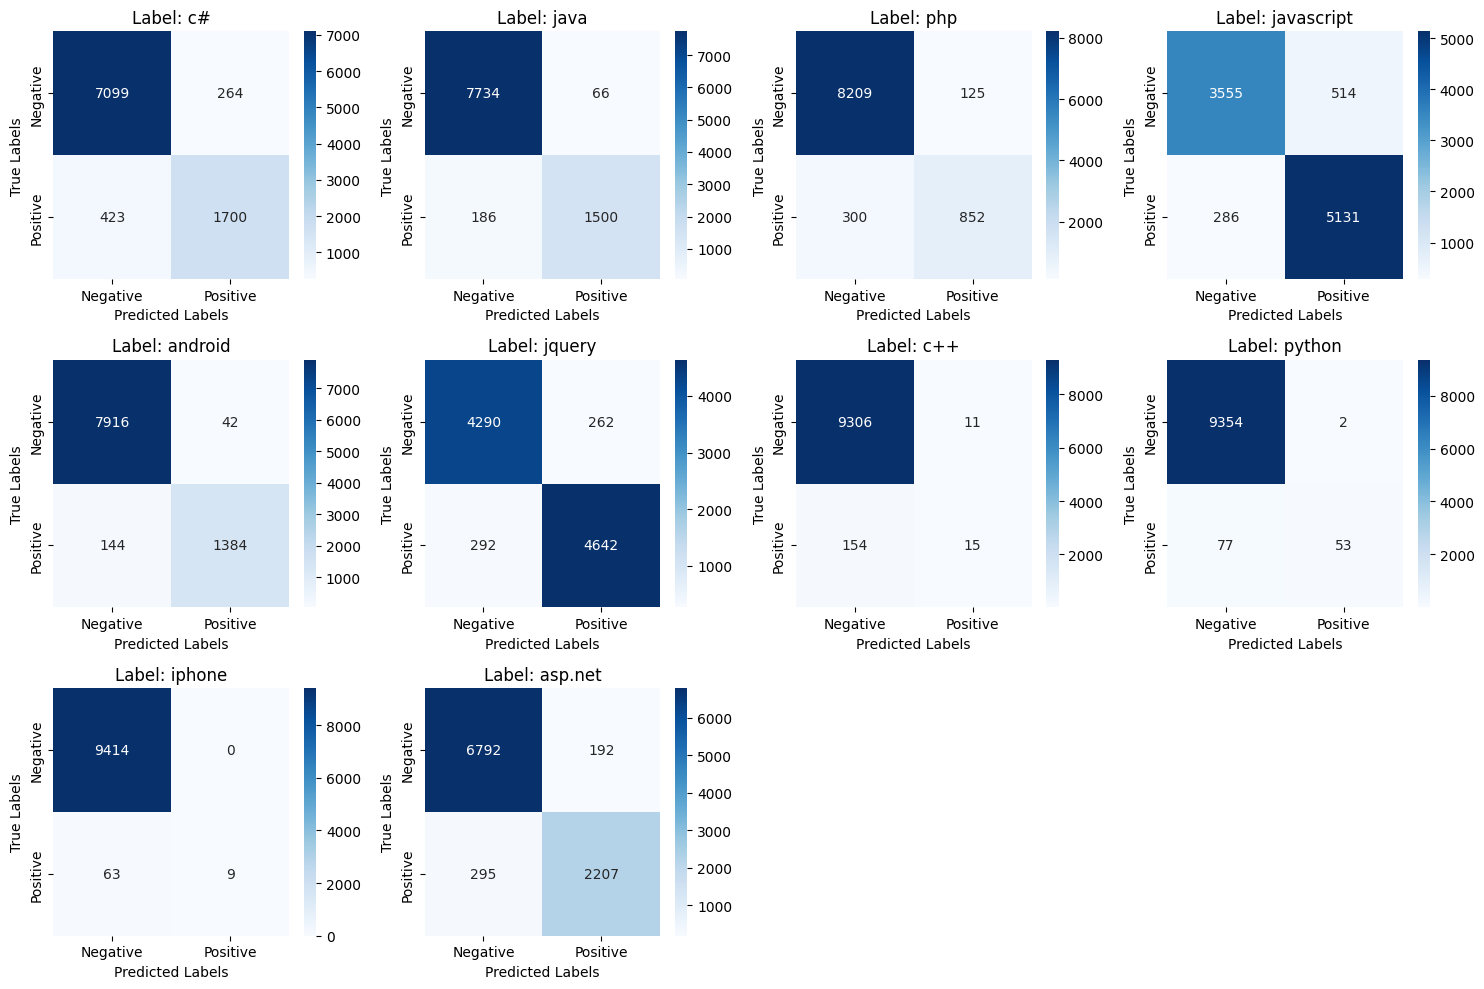

In [243]:
# Compute confusion matrices for test set
test_confusion_matrices = multilabel_confusion_matrix(y_test_tensor.numpy(), test_predictions_binary)

# Plot confusion matrices for test set
plot_confusion_matrices(test_confusion_matrices, labels)


# <font color = 'indianred'>**(3) Evaluation** </font>

In [244]:
# Assuming new_data is a list of text samples
# Transform new text data into TF-IDF vectors
X_test_tfidf = vectorizer.transform(X_test_list)

In [245]:
# Move the model to the appropriate device
model.eval()
model.to(device)

# Convert TF-IDF vectors to PyTorch sparse tensors
new_data_sparse = torch.tensor(X_test_tfidf.todense(), dtype=torch.float32)

# Pass TF-IDF vectors through the model to get predictions (logits)
with torch.no_grad():
    logits = model(new_data_sparse)

In [246]:
# Convert logits to class labels
predicted_labels = (logits > 0.5).cpu().numpy()

# Map class labels to class names
predicted_class_names = []
for labels in predicted_labels:
    class_names = [mlb.classes_[i] for i, label in enumerate(labels) if label == 1]
    predicted_class_names.append(class_names)

In [247]:
sample_y = y_test_np[0:5]
sample_y

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 1]])

In [248]:
# Mapping dictionary
mapping = {0: 'c#', 1: 'java', 2: 'php', 3: 'javascript', 4: 'android', 5: 'jquery', 6: 'c++', 7: 'python', 8: 'iphone', 9: 'asp.net'}

# Convert numerical labels to class names using the mapping
actual_labels = [[mapping[i] for i, label in enumerate(sample) if label == 1] for sample in sample_y]

# Display the mapped labels
print(actual_labels)

[['c#', 'jquery', 'asp.net'], ['java', 'android'], ['javascript', 'jquery'], ['javascript', 'jquery'], ['c#', 'javascript', 'asp.net']]


In [249]:
# Slice the predicted_labels_binary array to select the first 5 rows and print them
# Convert boolean values to binary format (1s and 0s)
predicted_labels_binary = predicted_labels.astype(int)

for row in predicted_labels_binary[:5]:
    print(row)

[0 0 0 0 0 1 0 0 0 1]
[0 1 0 0 1 0 0 0 0 0]
[0 0 0 1 0 1 0 0 0 0]
[0 0 0 1 0 1 0 0 0 0]
[0 0 0 1 0 0 0 0 0 1]


In [250]:
# Create a list of class names
class_names = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Compare the predicted labels with the mapped labels
for i, (predicted, actual) in enumerate(zip(predicted_labels, actual_labels)):
    # Replace boolean values with class names
    predicted_class_names = [class_names[j] for j, label in enumerate(predicted) if label]
    actual_class_names = [class_names[j] for j, label in enumerate(actual) if label]

    print(f"Example {i + 1}:")
    print(f"Predicted Class Names: {predicted_class_names}")
    print(f"Actual Class Names:    {actual_class_names}")
    print()

Example 1:
Predicted Class Names: ['jquery', 'asp.net']
Actual Class Names:    ['c#', 'java', 'php']

Example 2:
Predicted Class Names: ['java', 'android']
Actual Class Names:    ['c#', 'java']

Example 3:
Predicted Class Names: ['javascript', 'jquery']
Actual Class Names:    ['c#', 'java']

Example 4:
Predicted Class Names: ['javascript', 'jquery']
Actual Class Names:    ['c#', 'java']

Example 5:
Predicted Class Names: ['javascript', 'asp.net']
Actual Class Names:    ['c#', 'java', 'php']

